# Problem Statement and Context

**Enhancing Defect Detection in Manufacturing Processes Using Advanced Image Segmentation Techniques.**

In the manufacturing industry, quality control is critical for maintaining product standards and customer satisfaction. Detecting defects in products, such as steel sheets, can be challenging due to the high volume and speed of production. Manual inspection is not only time-consuming but also prone to human error, leading to inconsistent quality checks and potential financial losses.

# Objective
To develop an automated, accurate, and efficient defect detection system using advanced image segmentation models. The system will leverage deep learning techniques, particularly the LinkNet architecture, to identify and classify defects in real-time, ensuring high-quality production standards and reducing operational costs.

# Business Impact

* **Increased Accuracy**: Automated defect detection minimizes human errors, ensuring consistent quality checks.

* **Cost Efficiency**: Reduces the need for manual inspection, saving labor costs and increasing throughput.

* **Real-time Detection**: Enables immediate identification and rectification of defects, preventing defective products from reaching customers.

* **Improved Customer Satisfaction**: Enhances product reliability and quality, leading to higher customer satisfaction and loyalty.

* **Data-Driven Insights**: Provides valuable data for continuous improvement in manufacturing processes and defect prevention strategies.


# Key Metrics

* **Detection Accuracy**: The percentage of correctly identified defects compared to the total number of defects.
False Positive Rate: The rate of incorrectly identified defects.

* **Processing Time**: The time taken to process and identify defects in a given batch of products.

* **Cost Savings**: Reduction in labor costs and losses due to defective products.

* **Customer Satisfaction Scores**: Improvement in customer feedback and reduction in product returns due to defects.

By implementing this automated defect detection system, manufacturing companies can enhance their quality control processes, reduce operational costs, and improve overall product quality, thereby gaining a competitive edge in the market.

## Keras Environment
___

In [1]:
### Basic Library
import numpy as np, pandas as pd, os 
import gc
import ctypes
import random
from collections import defaultdict
import sys
from tqdm import tqdm
import time
import math 
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

# Pillow Library 
import cv2
from PIL import Image
import albumentations as albu

### TensorFlow Library
import tensorflow as tf
print('Tensorflow Version: ', tf.__version__)
import keras
from tensorflow.keras import *
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau


### Environment Setting 
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1' # GPU T4x2
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3' # Logging Lowest Level
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy("/gpu:0")
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
    print(f'Using {len(gpus)} GPUs')
    
import warnings 
warnings.filterwarnings('ignore')

2024-08-07 06:55:44.276109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 06:55:44.276204: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 06:55:44.409966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.15.0
Using 2 GPUs


In [2]:
!pip -q install palettable
from palettable.colorbrewer.qualitative import Pastel1_7

In [3]:
def tensorflow_seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)

    
tensorflow_seed_everything(42)
print('To Make Similar outputs with each runs')

## If you like randomness, It's not Necessary

To Make Similar outputs with each runs


In [6]:
def clean_memory():
    gc.collect()
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    
clean_memory()

**AMP(Auto Mixed Precision)** 

In [7]:
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


## Segmentations
___

#### Installation with PIP

In [8]:
# PyPI stable package
!pip install -q -U segmentation-models

# PyPI latest package
# !pip install -U --pre segmentation-models

# Source latest version 
# !pip install -q git+https://github.com/qubvel/segmentation_models

In [9]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models

Segmentation Models: using `tf.keras` framework.


# Importing the Dataset

In [10]:
df_train = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
print('Shape of DataFrame: ', df_train.shape)

Shape of DataFrame:  (7095, 3)


**Let's make Path**

In [11]:
mapping_path = {os.path.basename(x): x for x in glob(os.path.join('/kaggle','input','*','train_images','*.jpg'))}

df_train['path'] = df_train['ImageId'].map(mapping_path)

### Basic EDAs

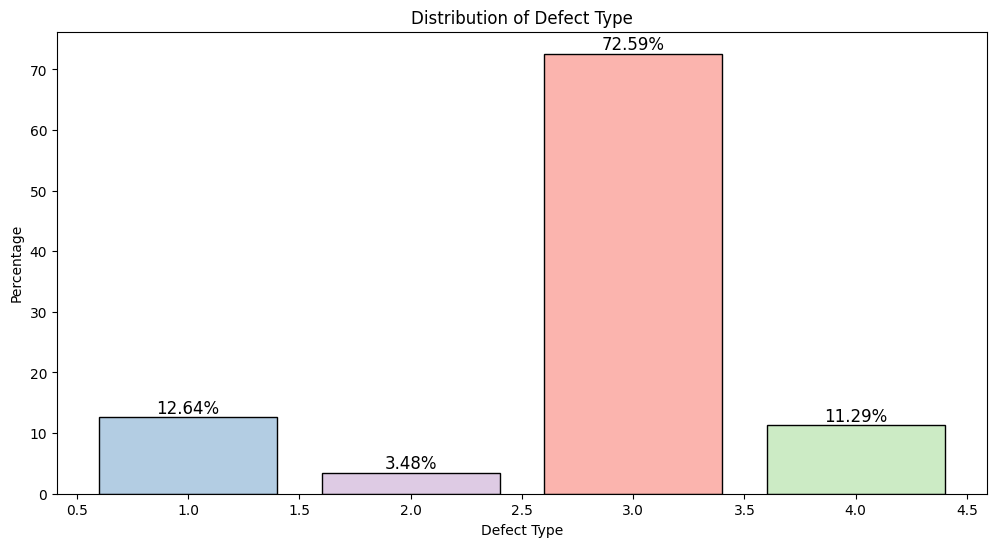

In [12]:
tmp = df_train['ClassId'].value_counts()

plt.figure(figsize=(12,6))
plt.title('Distribution of Defect Type')
ax = plt.bar(tmp.index, tmp.values/np.sum(tmp.values)*100, color=Pastel1_7.hex_colors, edgecolor='black')
for rect in ax:
    x = rect.get_x() + rect.get_width()/2.0
    y = rect.get_height()
    plt.text(x,y, f'{y:.2f}%', ha='center', va='bottom', size=12)
plt.xlabel('Defect Type')
plt.ylabel('Percentage')
plt.show()

**Observations**
* Defect Type 3 (Red Bar):
This defect type is the most common, representing 72.59% of the total defects.
This indicates a significant prevalence of this defect type in the dataset.

* Defect Type 1 (Blue Bar):
This is the second most common defect type, accounting for 12.64% of the total defects.
This shows a noticeable, but much lower occurrence compared to defect type 3.

* Defect Type 4 (Green Bar):
This defect type constitutes 11.29% of the total defects.
Similar to defect type 1, it has a considerable presence but is still significantly less common than defect type 3.

* Defect Type 2 (Purple Bar):
This is the least common defect type, making up only 3.48% of the total defects.
This suggests that this type of defect is relatively rare in the dataset.

**Conclusion**
The chart reveals a skewed distribution of defect types, with defect type 3 being overwhelmingly prevalent. This insight could be crucial for prioritizing quality control measures and targeting specific defects that occur most frequently in the manufacturing process.

**Actionable Insights**
* Focus on Defect Type 3: Since it is the most common, it should be the primary target for defect reduction strategies.
* Monitor Defect Types 1 and 4: These also occur relatively frequently and should be monitored to prevent them from increasing.
* Rare Defects: While defect type 2 is rare, it should still be addressed to ensure overall quality improvement.

This chart helps in understanding which defects are most prevalent and where quality control efforts should be concentrated to improve the overall manufacturing process.

### Let's See Image

**Image Size & Ratio**

In [13]:
%%time
img_size = []

for i in tqdm(df_train['path']):
    img = Image.open(i)
    img = np.array(img)
    img_size.append(img.shape[:2])
        
    
height =[size[0] for size in img_size]
width = [size[1] for size in img_size]
ratio = [size[0]/size[1] for size in img_size]

100%|██████████| 7095/7095 [01:18<00:00, 90.11it/s] 

CPU times: user 22.3 s, sys: 1 s, total: 23.3 s
Wall time: 1min 18s


In [14]:
print('Mean of Image Height: ', int(np.mean(height)))
print('Mean of Image Width: ', int(np.mean(width)))
print(f'Mean of Image Ratio: {np.mean(ratio):.2f}')

Mean of Image Height:  256
Mean of Image Width:  1600
Mean of Image Ratio: 0.16


**Image Channel**

In [15]:
%%time
mean_red_channel = []
mean_green_channel = []
mean_blue_channel = []
std_red_channel = []
std_green_channel = []
std_blue_channel = []

for i in tqdm(df_train['path']):
    img = Image.open(i)
    img = np.array(img)
    
    # Rescale
    img = img/255.0
    
    mean_red_channel.append(np.mean(img[:,:,0]))
    mean_green_channel.append(np.mean(img[:,:,1]))
    mean_blue_channel.append(np.mean(img[:,:,2]))
    
    std_red_channel.append(np.std(img[:,:,0]))
    std_green_channel.append(np.std(img[:,:,1]))
    std_blue_channel.append(np.std(img[:,:,2]))

100%|██████████| 7095/7095 [01:13<00:00, 96.53it/s] 

CPU times: user 1min 9s, sys: 853 ms, total: 1min 10s
Wall time: 1min 13s


In [16]:
channels = ['Red'] * len(mean_red_channel) + ['Green'] * len(mean_green_channel) + ['Blue'] * len(mean_blue_channel)
means = mean_red_channel + mean_green_channel + mean_blue_channel

df_mean = pd.DataFrame({'Channel': channels, 'Mean': means})


stds = std_red_channel + std_green_channel + std_blue_channel
df_std = pd.DataFrame({'Channel': channels, 'Std': stds})

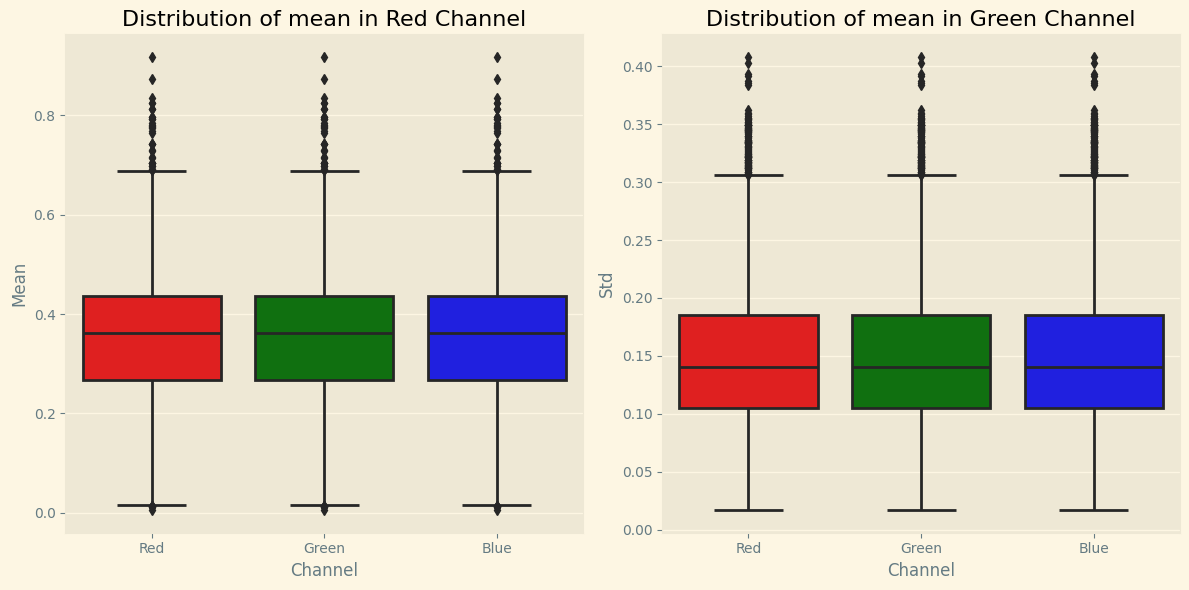

In [17]:
custom_palette = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}

plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('Distribution of mean in Red Channel')
sns.boxplot(x='Channel', y='Mean', data=df_mean, palette=custom_palette)

plt.subplot(1,2,2)
plt.title('Distribution of mean in Green Channel')
sns.boxplot(x='Channel', y='Std', data=df_std, palette=custom_palette)

plt.tight_layout()
plt.show()

The provided image consists of two box plots side by side, showing the distribution of pixel values for the red, green, and blue channels in an image dataset. Each box plot gives insights into the mean and standard deviation (std) of these channels.

* Left Plot: Distribution of Mean in Each Color Channel
Title: "Distribution of mean in Red Channel"

X-Axis (Channel): Displays the color channels: Red, Green, and Blue.
Y-Axis (Mean): Shows the mean values of the pixel intensities for each channel.
Observations:

Red Channel (Red Box):

The median (middle line in the box) is around 0.4.
The interquartile range (IQR), which is the box itself, spans from approximately 0.3 to 0.5.
Whiskers extend to roughly 0.0 to 0.7, with several outliers beyond 0.7.
Green Channel (Green Box):

The median is close to 0.4.
The IQR ranges from about 0.3 to 0.5.
Whiskers extend from around 0.0 to 0.7, with some outliers beyond this range.
Blue Channel (Blue Box):

The median is also around 0.4.
The IQR is similar, ranging from about 0.3 to 0.5.
Whiskers extend to 0.0 to 0.7, with several outliers beyond this range.
Interpretation:

The mean values for the red, green, and blue channels are similar, with most pixel intensities clustered around 0.4.
There are some outliers with higher pixel intensities.

* Right Plot: Distribution of Standard Deviation in Each Color Channel
Title: "Distribution of mean in Green Channel"

X-Axis (Channel): Displays the color channels: Red, Green, and Blue.
Y-Axis (Std): Shows the standard deviation of the pixel intensities for each channel.
Observations:

Red Channel (Red Box):

The median standard deviation is around 0.15.
The IQR spans from approximately 0.1 to 0.2.
Whiskers extend from about 0.0 to 0.3, with several outliers beyond 0.3.
Green Channel (Green Box):

The median standard deviation is close to 0.15.
The IQR ranges from about 0.1 to 0.2.
Whiskers extend from around 0.0 to 0.3, with some outliers beyond this range.
Blue Channel (Blue Box):

The median standard deviation is also around 0.15.
The IQR is similar, ranging from about 0.1 to 0.2.
Whiskers extend to 0.0 to 0.3, with several outliers beyond this range.
Interpretation:

The standard deviation values for the red, green, and blue channels are similar, indicating consistent variability in pixel intensities across the channels.
There are some outliers with higher variability in pixel intensities.

* Overall Summary:
The means and standard deviations of the red, green, and blue channels are quite similar, suggesting uniform lighting or color distribution in the images.
The presence of outliers indicates occasional variations in pixel intensities, which might be due to specific features or anomalies in the images.

These plots are useful for understanding the overall color distribution and variability in an image dataset, which is critical for tasks such as image segmentation or classification.

## Keras UNet Model
___

### Build DataGenerator

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=False, mode='train', transform=False, preprocess=None):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle 
        self.mode = mode
        self.transform = transform 
        self.on_epoch_end()
        self.preprocess = preprocess
    
    def __len__(self):
        ## Drop_Last = True
        # return int(np.floor(len(self.data)/self.batch_size)))
        
        ## Drop_Last = False
        return int(np.ceil(len(self.data)/self.batch_size))
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X,y
    
    def __data_generation(self,indexes):
        # X = np.zeros(len(indexes))
        X = np.zeros((self.batch_size, 128, 800, 3), dtype=np.uint8)
        y = np.zeros((self.batch_size, 128,800, 1), dtype=np.float32)
        
        for j,i in enumerate(indexes):
            path = self.data.iloc[i]['path']
            img = Image.open(path)
            img = img.resize((800,128), Image.Resampling.LANCZOS) # efficiency
            img = np.array(img)       
            
            X[j,] = img 
            if self.preprocess != None: X = self.preprocess(X)
            if self.mode != 'test':
                y[j,:,:,0] = rle2maskResize(self.data.iloc[i]['EncodedPixels'])
        return X, y

In [19]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.resnet import ResNet50

eff_model = EfficientNetB0()
print('### EfficientNet Layer')
print(eff_model.layers[:5])
print('#'*25)
resnet_model = ResNet50()
print('###  ResNet Layer')
print(resnet_model.layers[:5])

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
### EfficientNet Layer
[<InputLayer name=input_layer, built=True>, <Rescaling name=rescaling, built=True>, <Normalization name=normalization, built=True>, <Rescaling name=rescaling_1, built=True>, <ZeroPadding2D name=stem_conv_pad, built=True>]
#########################
102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
###  ResNet Layer
[<InputLayer name=input_layer_1, built=True>, <ZeroPadding2D name=conv1_pad, built=True>, <Conv2D name=conv1_conv, built=True>, <BatchNormalization name=conv1_bn, built=True>, <Activation name=conv1_relu, built=True>]


#### Utils Functions
`rle`: Run-Length Encoding

ex)
mask: 000111001100001111100

rle(ignore 0): 4 3 8 2 13 5

In [20]:
def rle2maskResize(rle):
    # Convert rle to mask
    if (pd.isnull(rle))|(rle==''):
        return np.zeros((128,800), dtype=np.float32)
    
    height = 256
    width = 1600
    mask = np.zeros(width*height, dtype=np.float32)
    
    array = np.array([int(x) for x in rle.split(" ")])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        
    return mask.reshape((height,width), order='F')[::2,::2]

def mask2contour(mask, width=3):
    w = mask.shape[1]
    h = mask.shape[0]
    
    mask2 = np.concatenate([mask[:,width:], np.zeros((h,width))], axis=1)
    mask2 = np.logical_xor(mask,mask2)
    
    mask3 = np.concatenate([mask[width:,:], np.zeros((width,w))], axis=0)
    mask3 = np.logical_xor(mask, mask3)
 
    return np.logical_or(mask2,mask3)

### Display Steel Defect 

#########################
### Defect:1
#########################


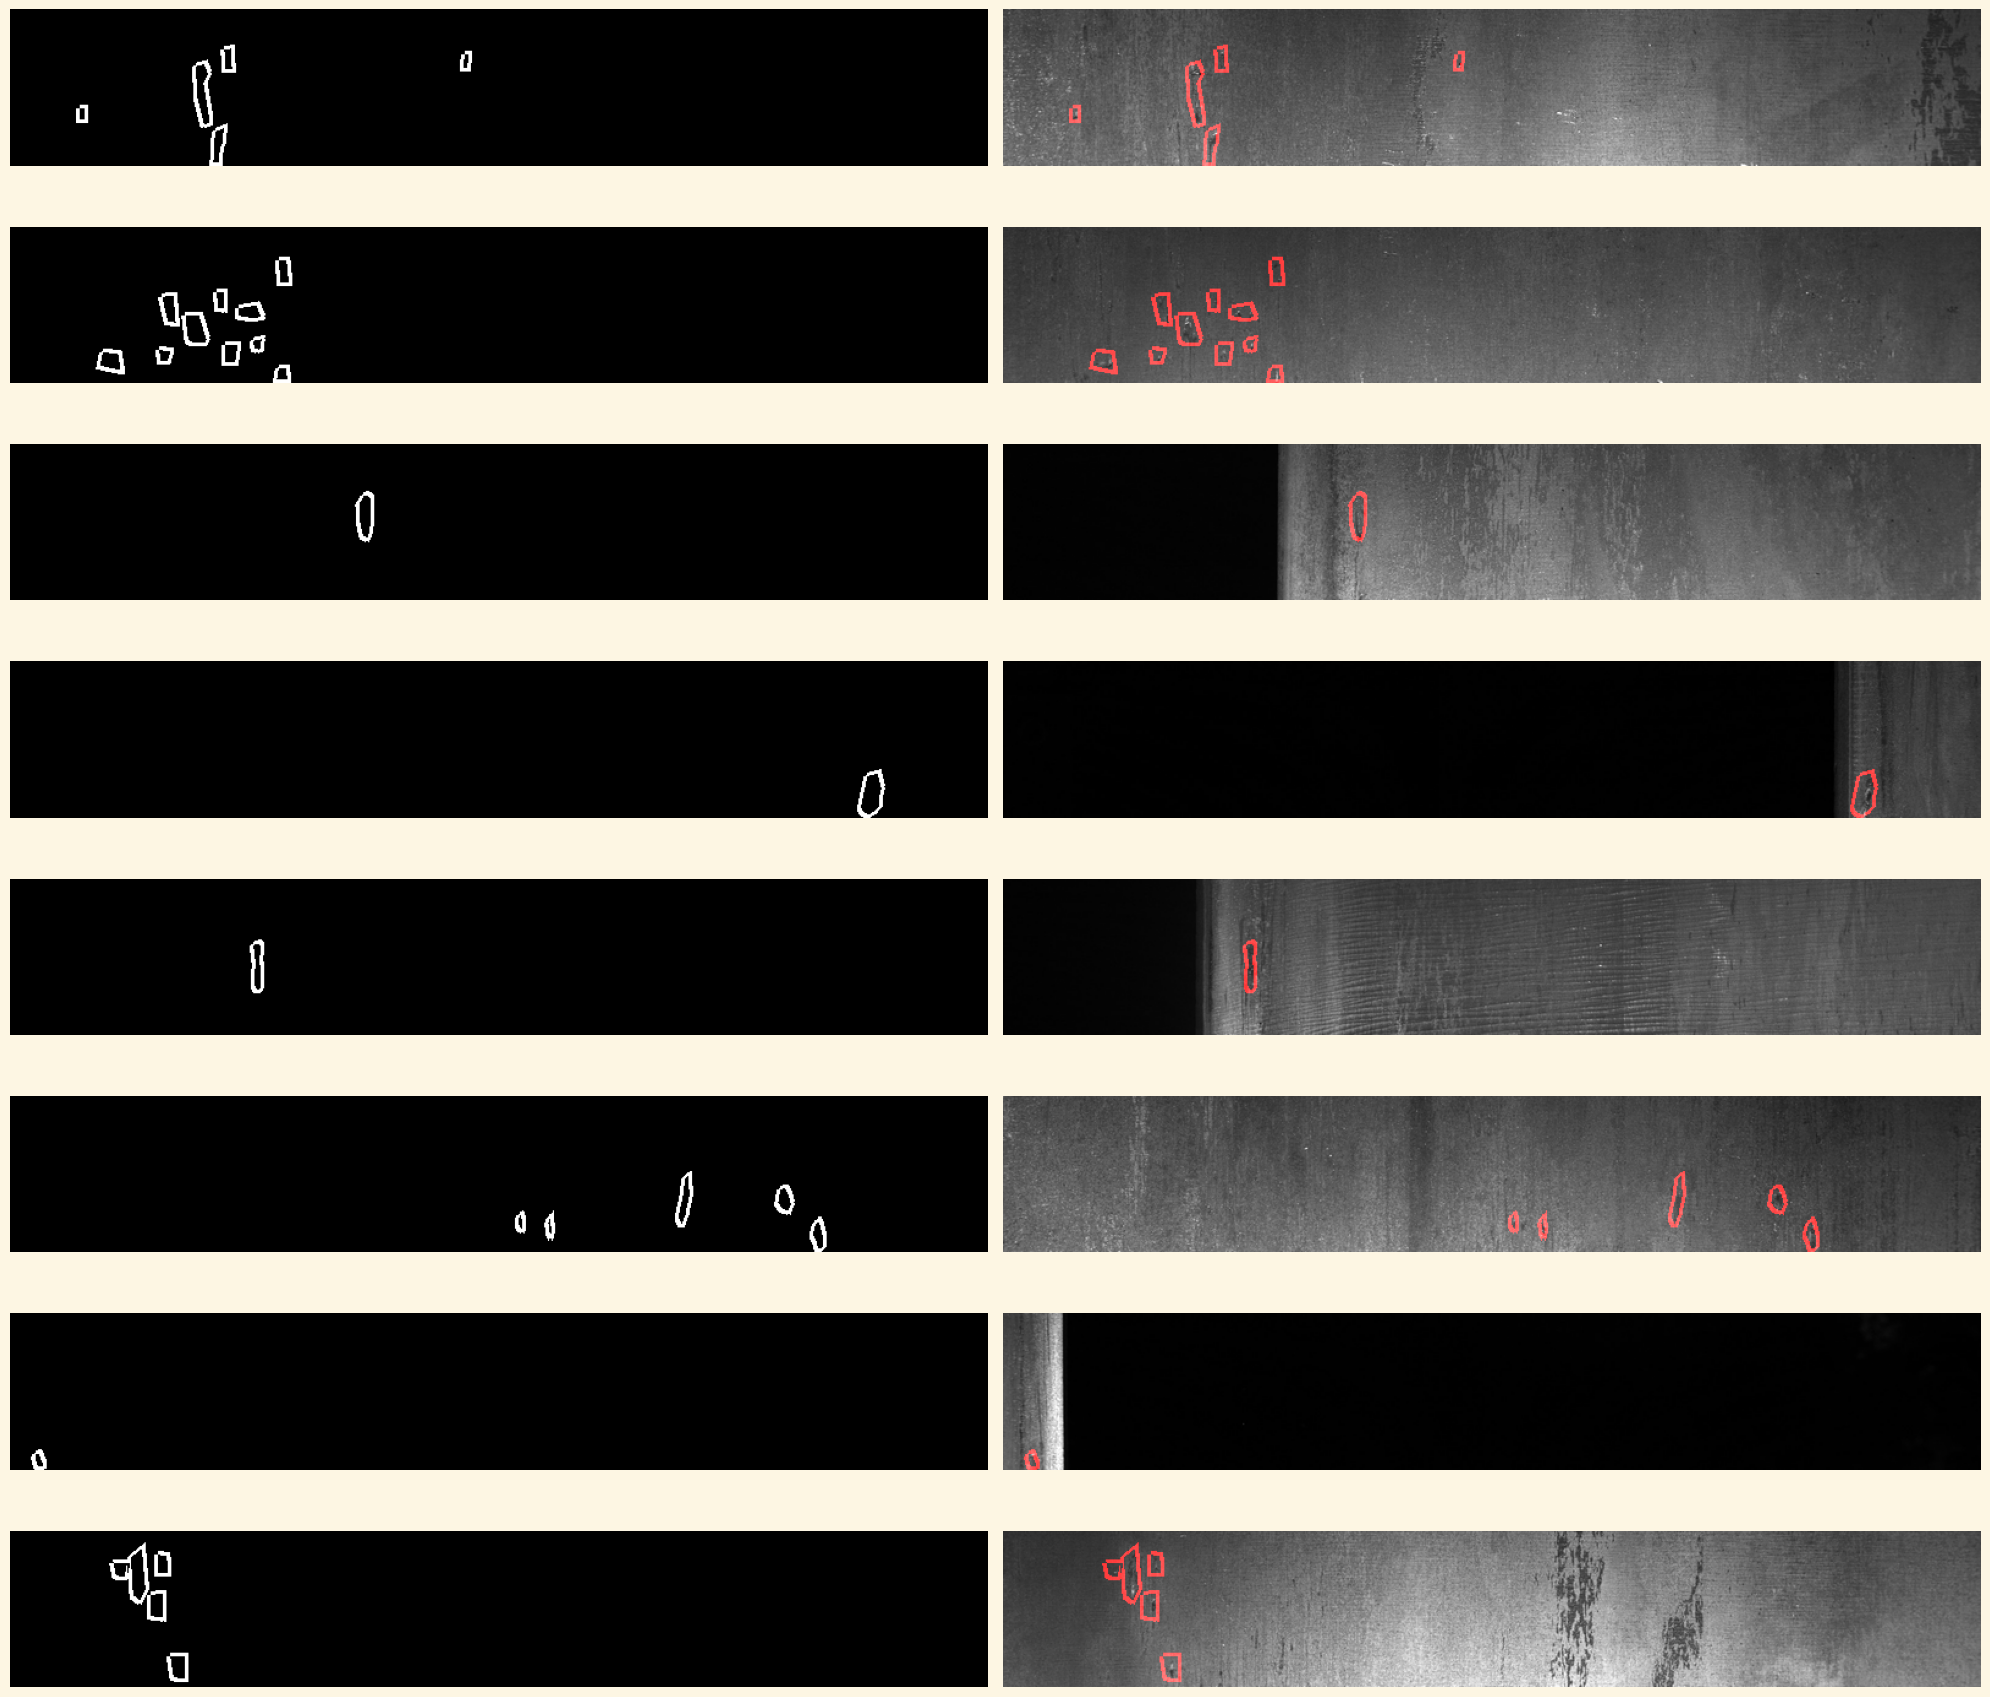

#########################
### Defect:2
#########################


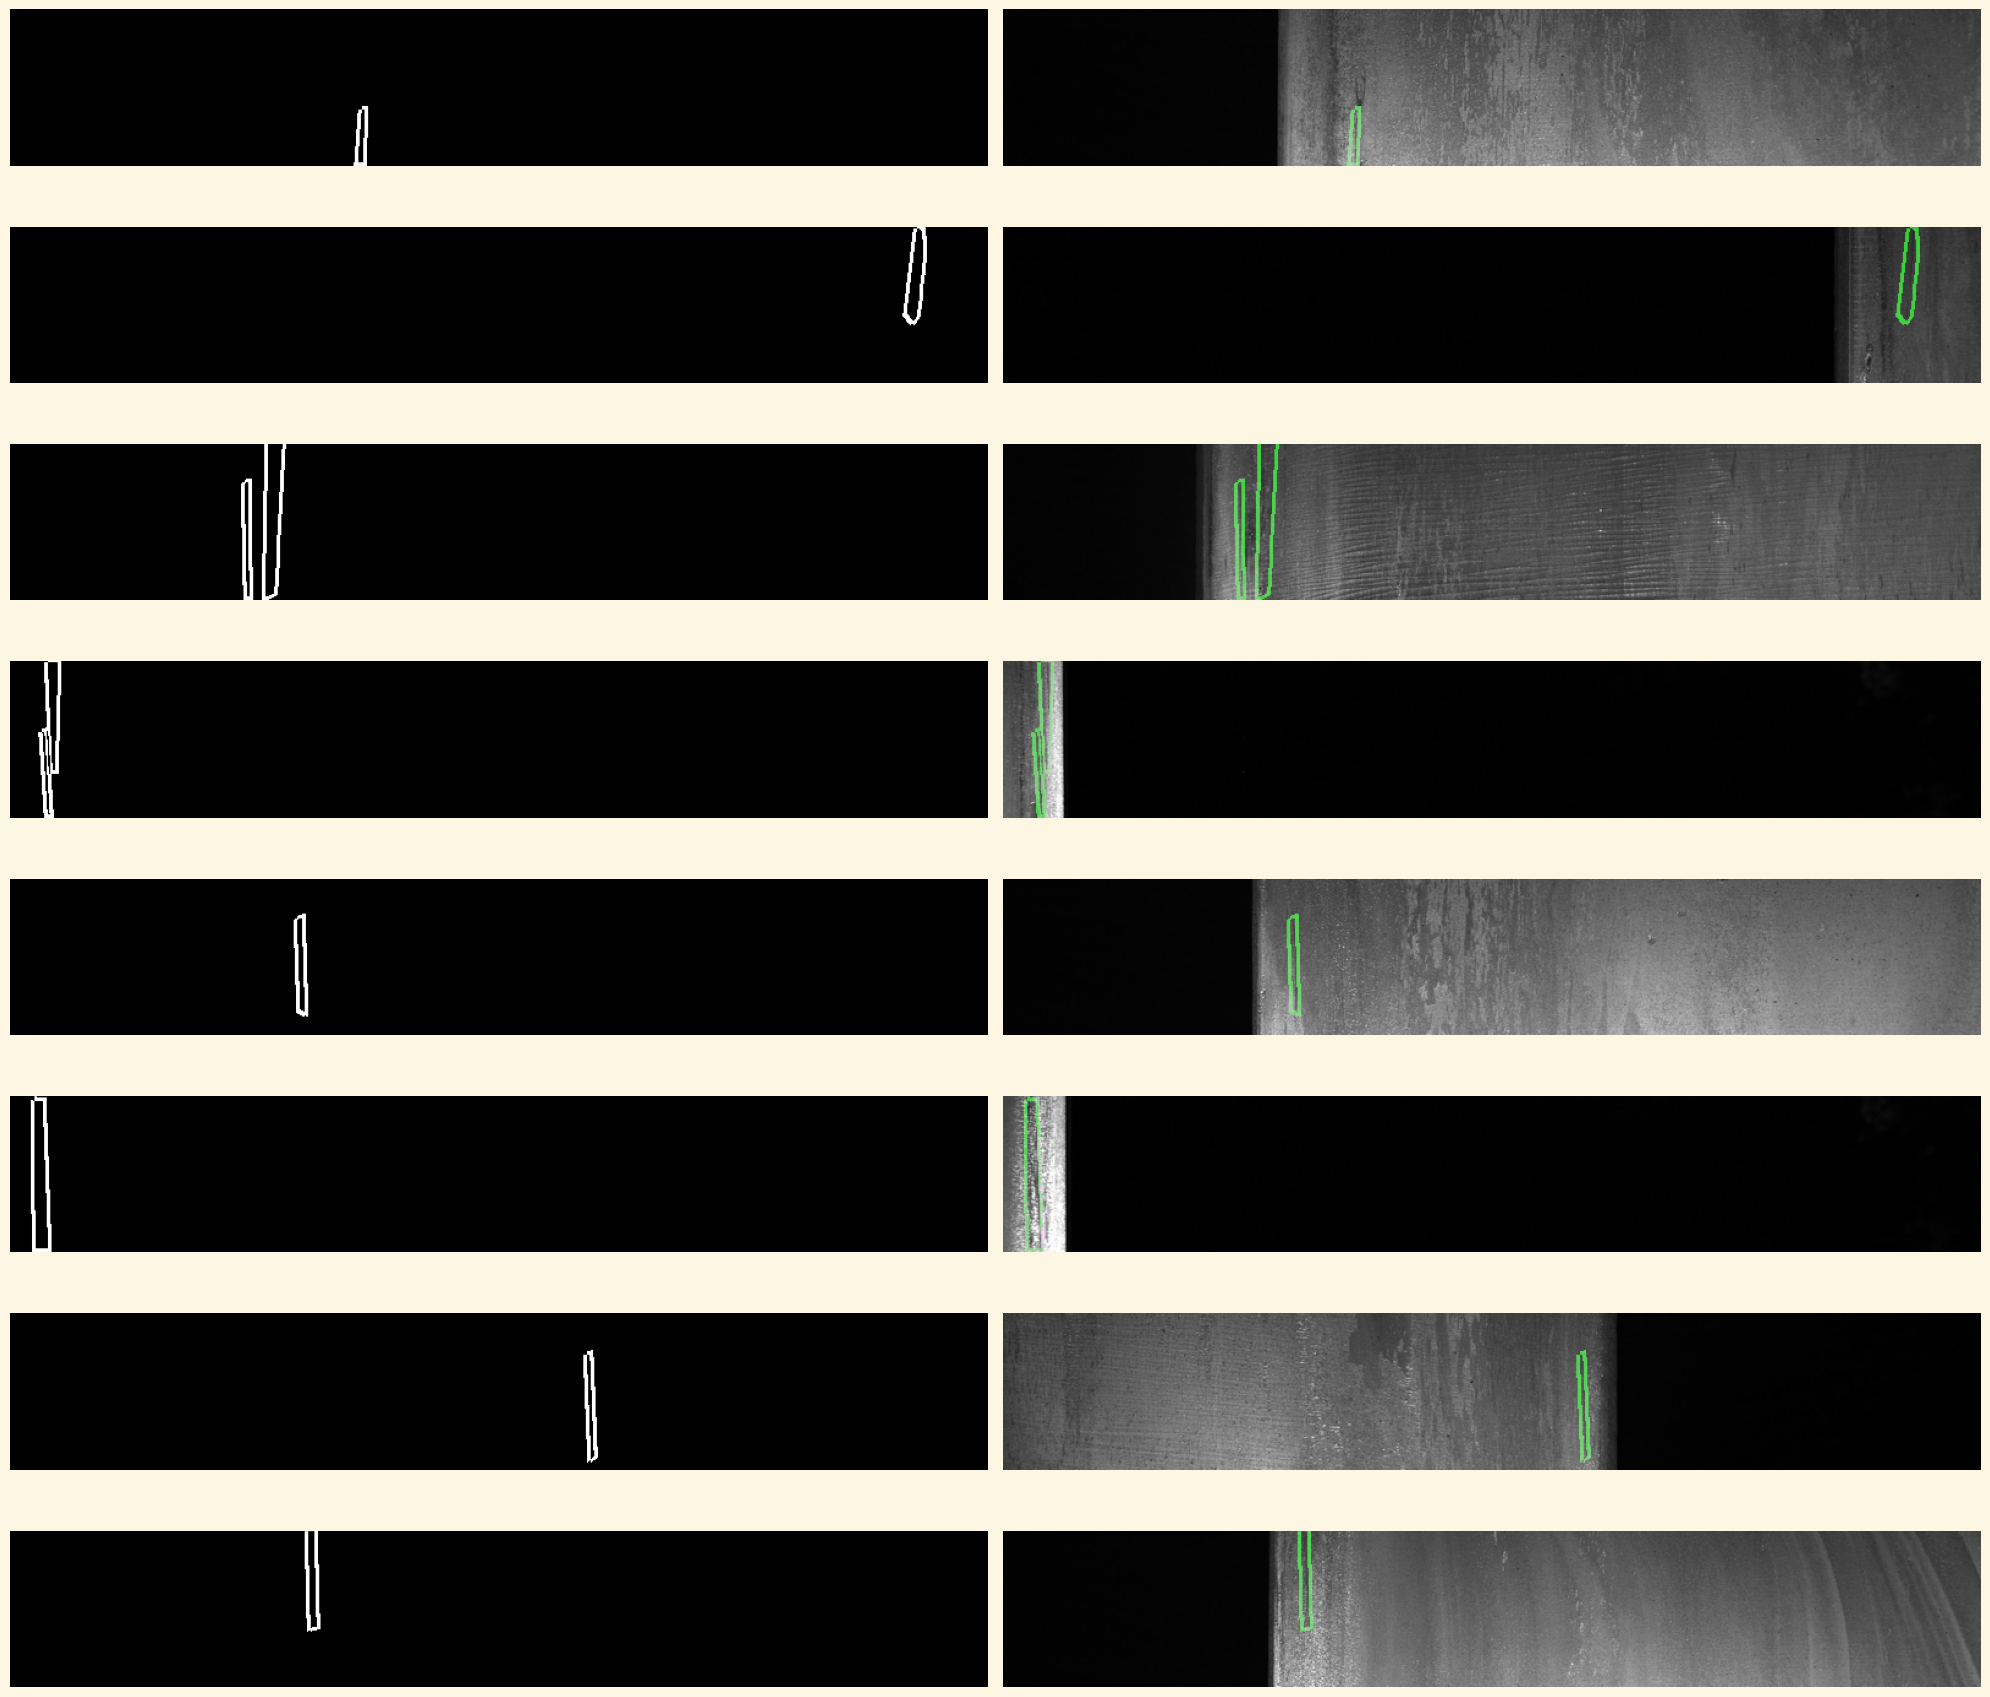

#########################
### Defect:3
#########################


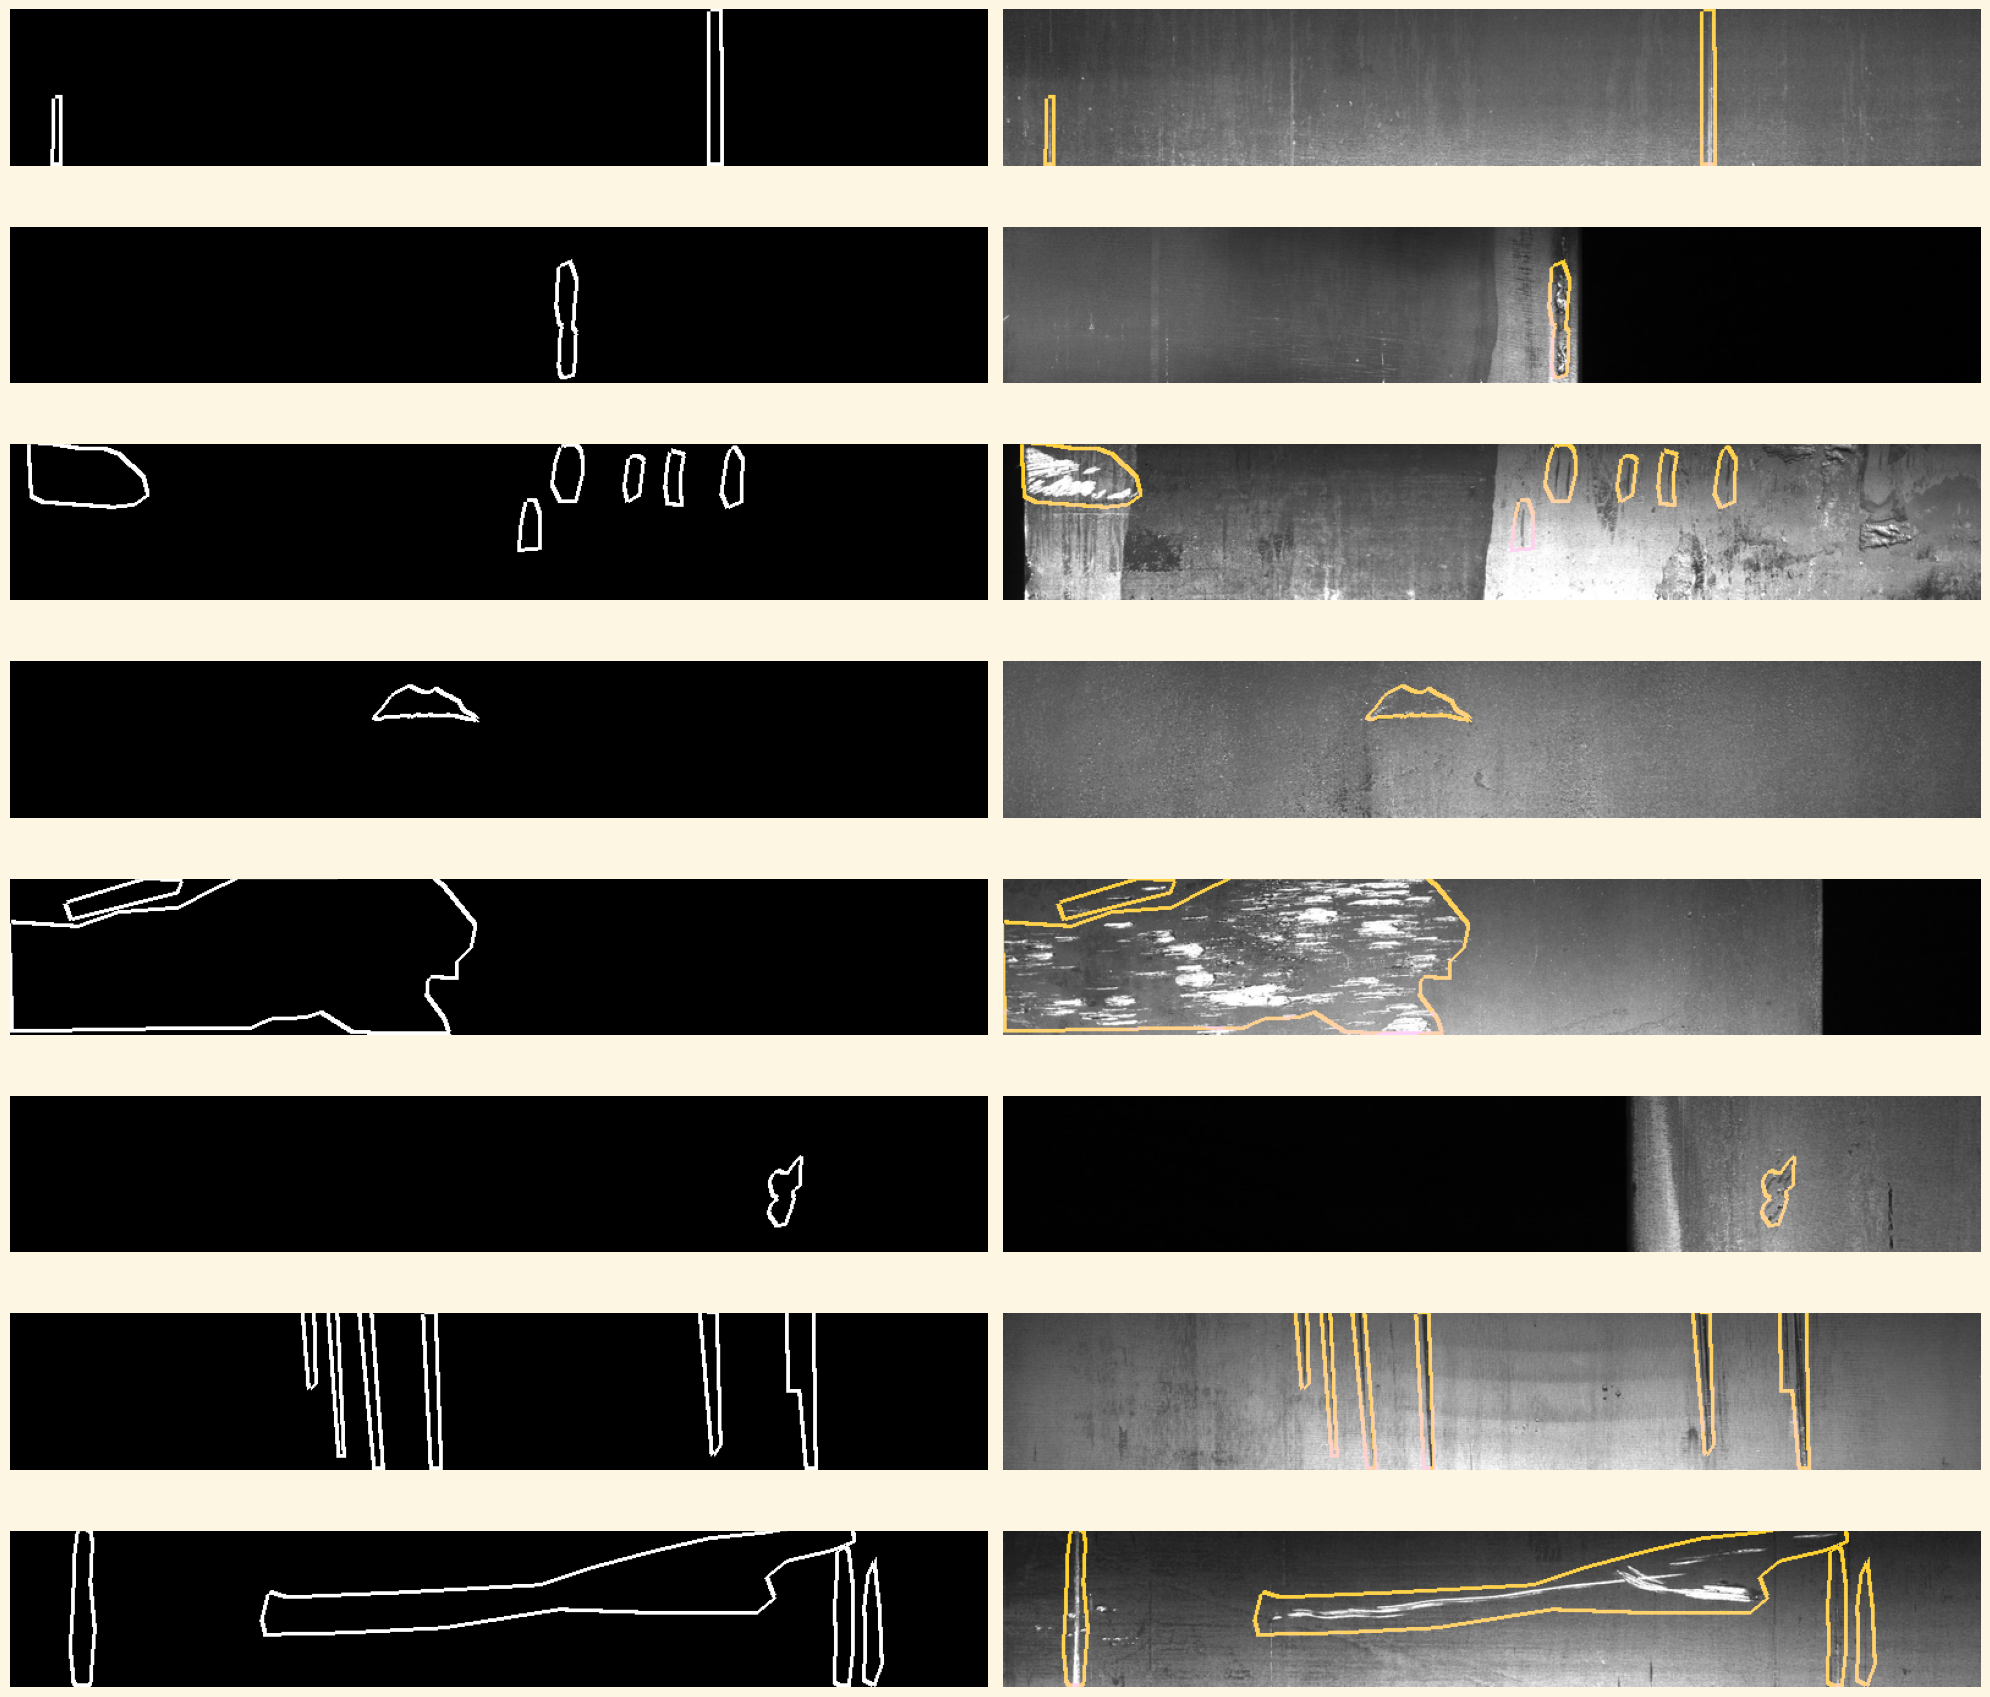

#########################
### Defect:4
#########################


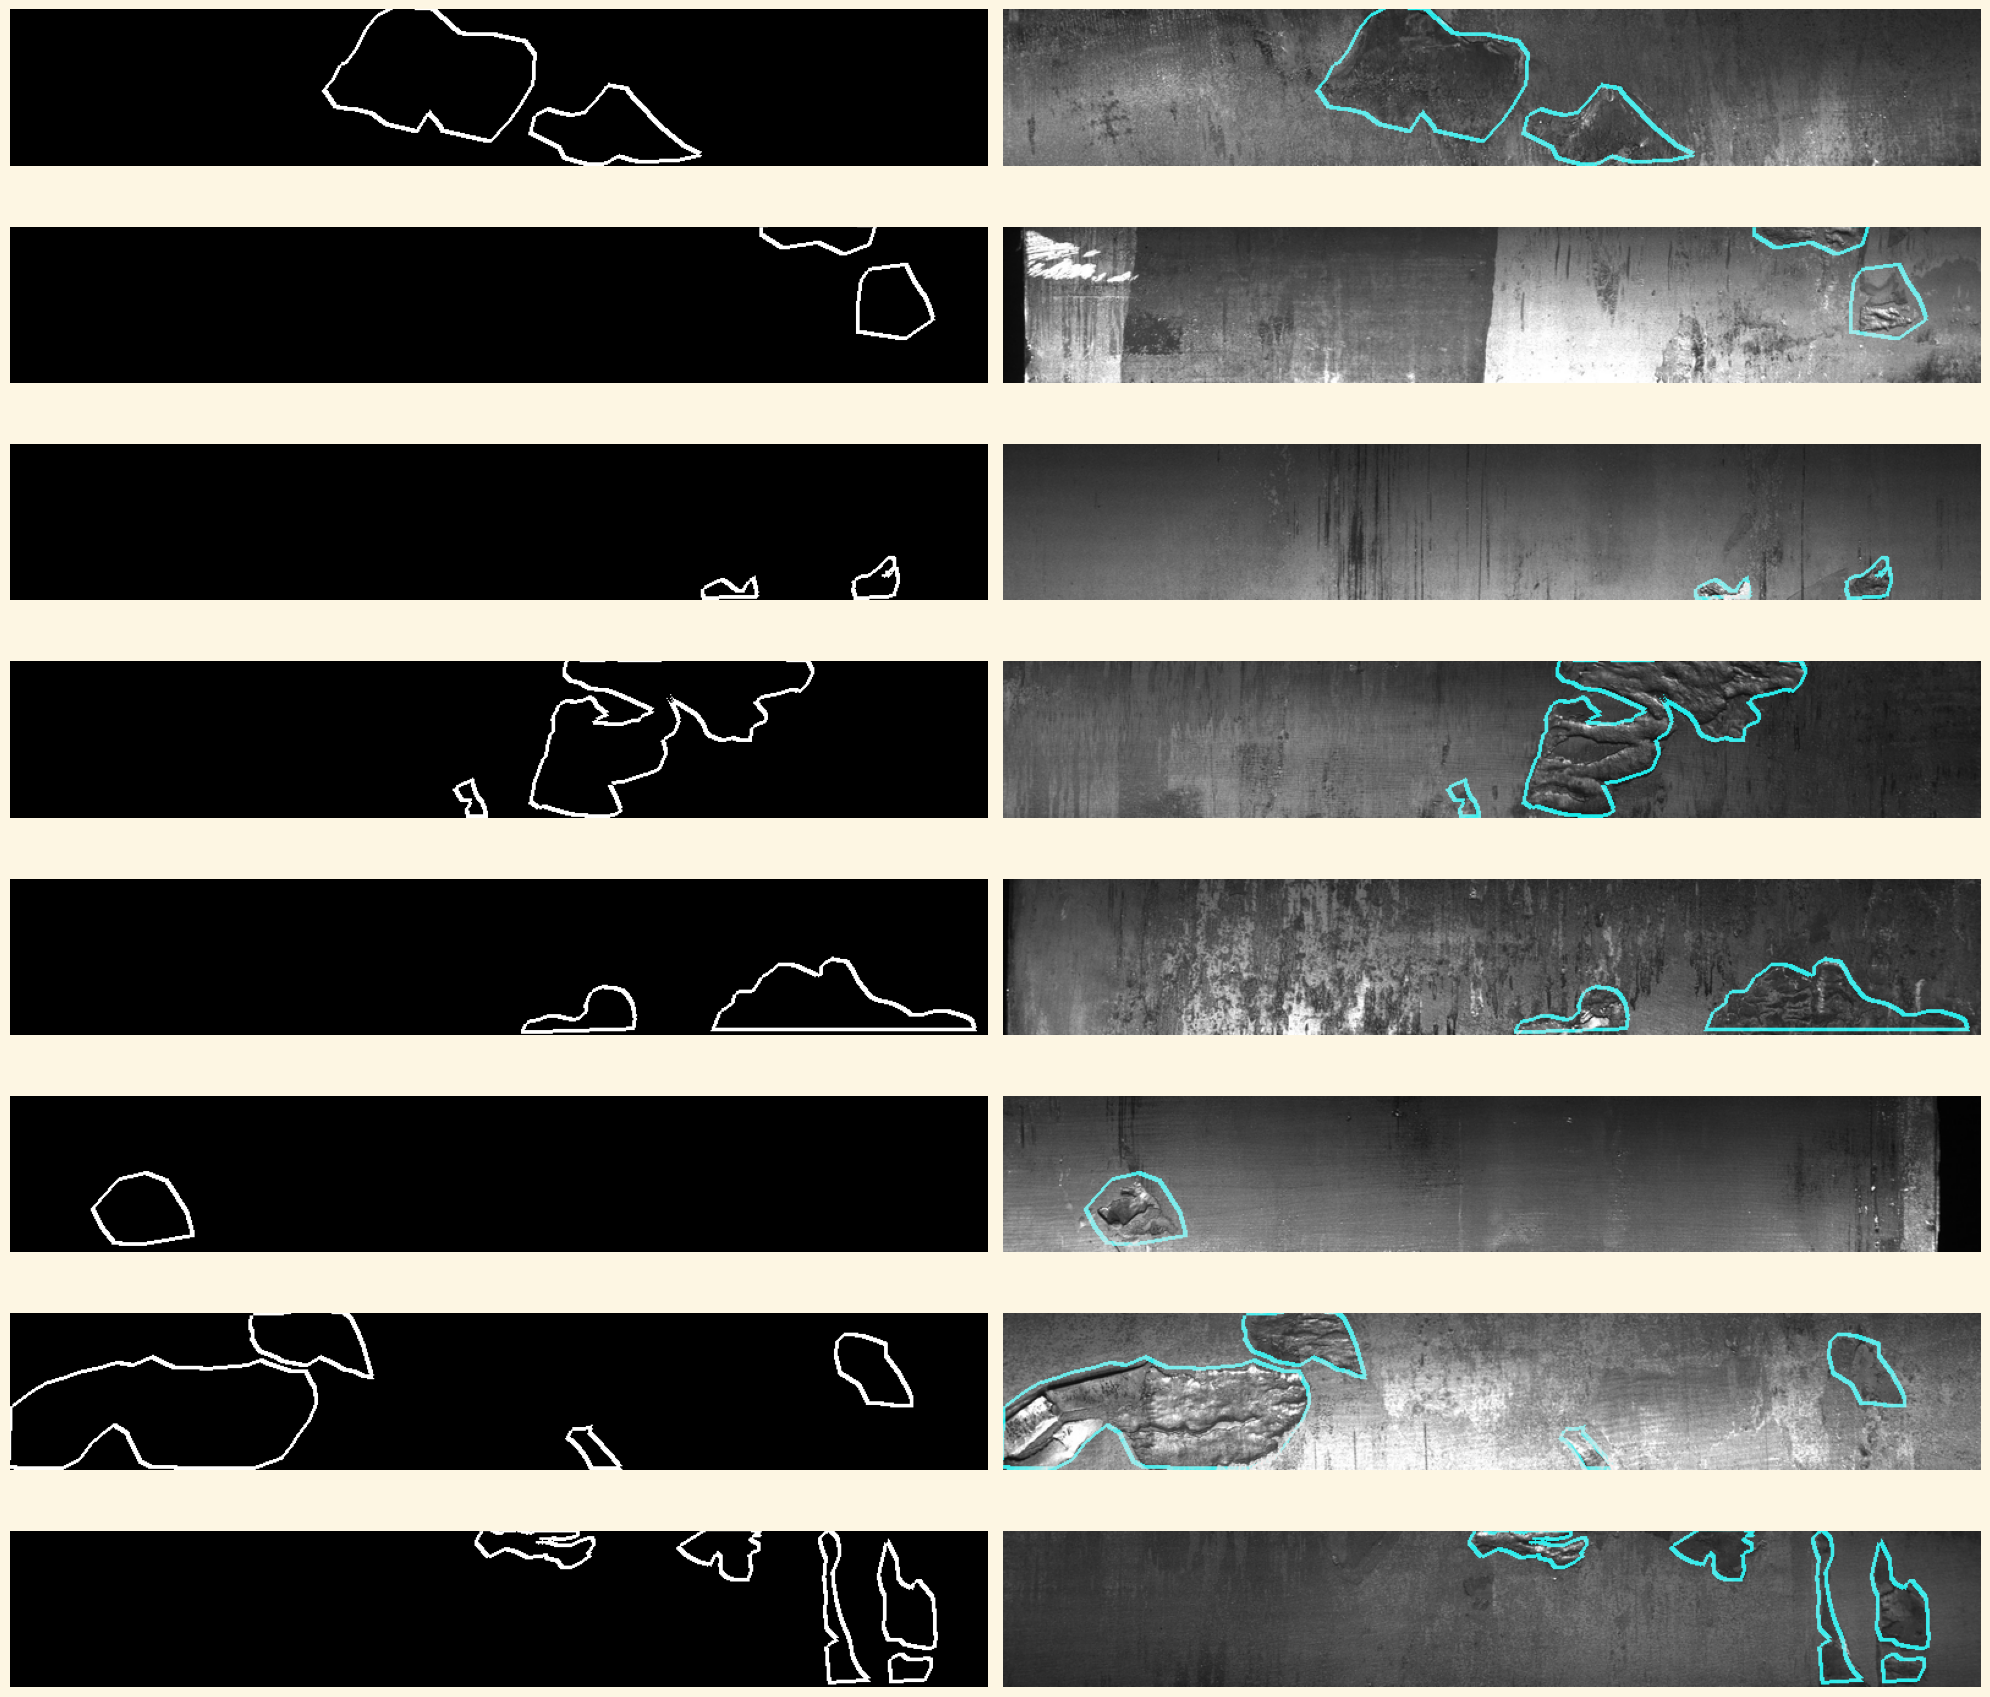

In [21]:
for k in range(df_train['ClassId'].nunique()):
    print('#'*25)
    print(f'### Defect:{k+1}')
    print('#'*25)
    
    tmp = df_train[df_train['ClassId'] == k+1]

    plt.figure(figsize=(20,18))
    for i in range(8):
        plt.subplot(8,2,2*i+1)
        img2 = rle2maskResize(tmp.iloc[i]['EncodedPixels'])
        img2 = mask2contour(img2)
        plt.imshow(img2,cmap='gray')
        plt.axis('off')
    
        path = tmp.iloc[i]['path']
        img = Image.open(path)
        img = img.resize((800,128), Image.Resampling.LANCZOS)
        img = np.array(img)

        if k == 0:
            img[:,:,0][img2==1] = 255 # Color: Red 
        elif k ==1: img[:,:,1][img2==1] = 210 # Color: Blue
        elif k ==2: # Color: Yellow 
            img[:,:,0][img2==1] = 255 
            img[:,:,1][img2==1] = 210
        else:  # Color: Blue + Green 
            img[:,:,1][img2==1] = 235
            img[:,:,2][img2==1] = 235
        plt.subplot(8,2,2*i+2)
    
        plt.imshow(img)
        plt.axis('off')
    plt.subplots_adjust(hspace=0.1)    
    plt.tight_layout()
    plt.show()    



In [22]:
# Simple Dice Coefficient Implementation

## For Numpy 
def dice_coefficient(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    first_sum = np.sum(mask1)
    second_sum = np.sum(mask2)
    dice = (2 * intersect) / (first_sum + second_sum)
    dice = np.mean(dice)
    dice = round(dice, 3)
    return dice 

# For Tensor(When Training in Model)
def dice_metric(y_true, y_pred, smooth=1):
    true_sum = K.sum(y_true)
    pred_sum = K.sum(y_pred)
    intersect = K.sum(y_true*y_pred)
    
    dice = (2*intersect) /(true_sum + pred_sum + smooth)
    return dice

**Two Same Mask**

In [23]:
mask = rle2maskResize(df_train.iloc[0]['EncodedPixels'])
print('Dice Coefficient with Two Same Masks: ', dice_coefficient(mask, mask))

Dice Coefficient with Two Same Masks:  1.0


**Shifted Original Mask**

In [24]:
mask = rle2maskResize(df_train.iloc[0]['EncodedPixels'])
shifted_mask1 = np.concatenate([mask[:,3:], np.zeros((128,3))], axis=1) 
shifted_mask2 = np.concatenate([mask[:,5:], np.zeros((128,5))], axis=1) 
shifted_mask3 = np.concatenate([mask[:,7:], np.zeros((128,7))], axis=1) 
print('Dice Coefficient with Shifted Mask1: ', dice_coefficient(mask, shifted_mask1))
print('Dice Coefficient with Shifted Mask2: ', dice_coefficient(mask, shifted_mask2))
print('Dice Coefficient with Shifted Mask3: ', dice_coefficient(mask, shifted_mask3))

Dice Coefficient with Shifted Mask1:  0.646
Dice Coefficient with Shifted Mask2:  0.414
Dice Coefficient with Shifted Mask3:  0.198


### Build Unet Model 

**Method: Using `Segmentation_models` Library**

In [25]:
from segmentation_models import Unet

res_preprocess = segmentation_models.get_preprocessing('resnet18')

unet_model = Unet('resnet18', input_shape=(128,800,3), classes=1, activation='sigmoid')
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_metric])

44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Let's See Unet Encoder Layer**

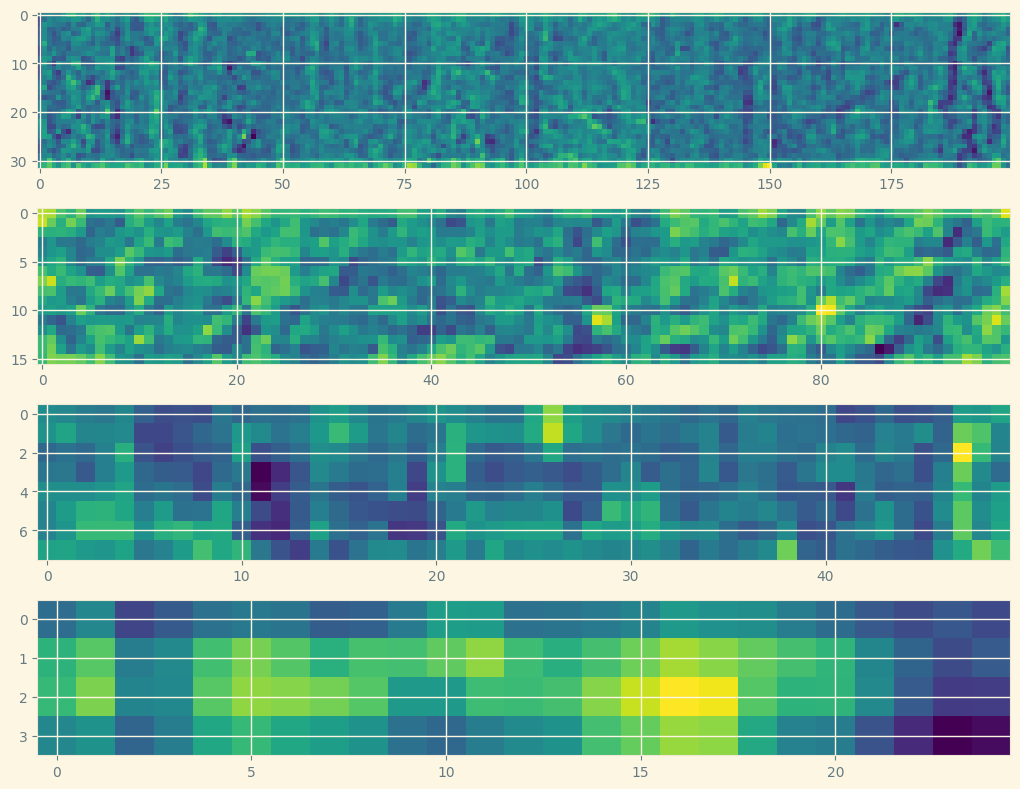

In [26]:
gen = DataGenerator(df_train)
img = gen[0][0][0:1]

stage1 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('add_1').output)
stage2 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('add_3').output)
stage3 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('add_5').output)
stage4 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('add_7').output)

output1 = stage1(img)
output2 = stage2(img)
output3 = stage3(img)
output4 = stage4(img)

plt.figure(figsize=(20,8))
for i, feature in enumerate([output1,output2,output3,output4]):
    plt.subplot(4,1,i+1)
    plt.imshow(feature[0,:,:,0])

plt.tight_layout()
plt.show()

**Let's See Unet Decoder Layer**

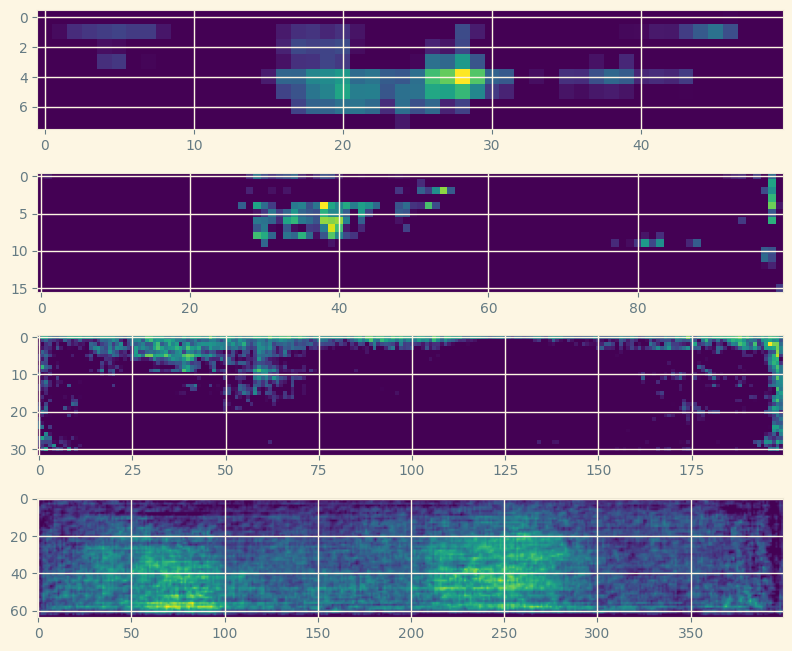

In [27]:
gen = DataGenerator(df_train)
img = gen[0][0][0:1]

stage1 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('decoder_stage0b_relu').output)
stage2 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('decoder_stage1b_relu').output)
stage3 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('decoder_stage2b_relu').output)
stage4 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('decoder_stage3b_relu').output)
stage5 = Model(inputs=unet_model.input, outputs=unet_model.get_layer('decoder_stage4b_relu').output)

output1 = stage1(img)
output2 = stage2(img)
output3 = stage3(img)
output4 = stage4(img)
output5 = stage5(img)

plt.figure(figsize=(20,8))
for i, feature in enumerate([output1,output2,output3,output4]):
    plt.subplot(5,1,i+1)
    plt.imshow(feature[0,:,:,0])

plt.tight_layout()
plt.show()

**Train & Valid Split**

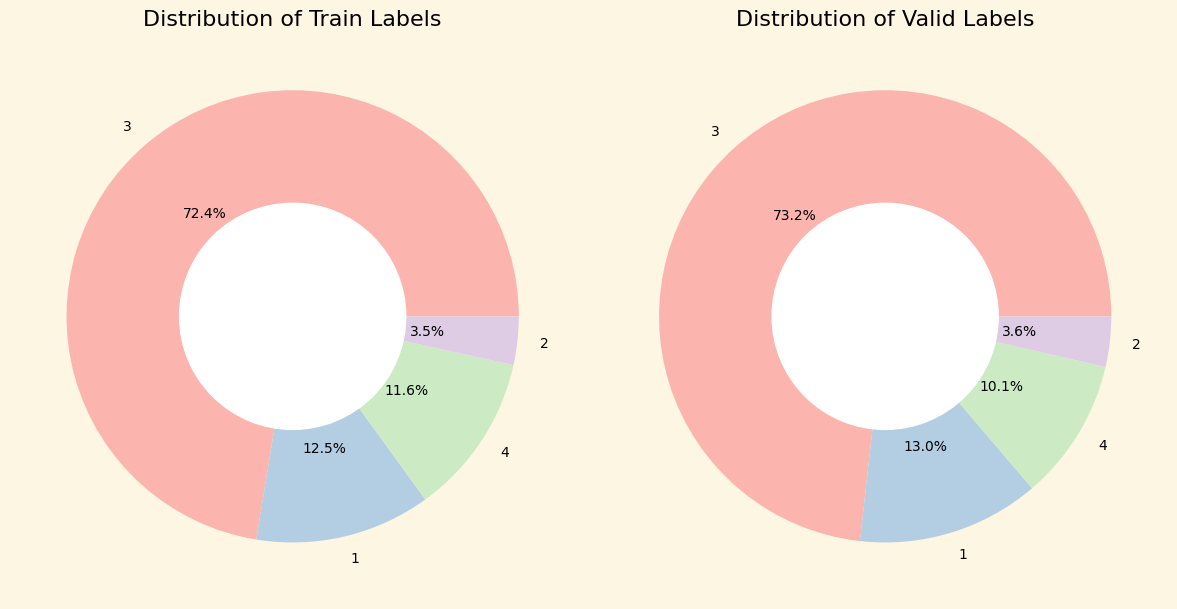

In [28]:
# Train & Valid Split

from sklearn.model_selection import train_test_split
train_index, valid_index = train_test_split(df_train.index, test_size=0.2, random_state=42, shuffle=True)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Distribution of Train Labels')
plt.pie(df_train.iloc[train_index]['ClassId'].value_counts(), labels=df_train.iloc[train_index]['ClassId'].value_counts().index, 
        autopct='%.1f%%', colors=Pastel1_7.hex_colors)
my_circle1 = plt.Circle((0, 0), 0.5, color='white')
p1 = plt.gcf()
p1.gca().add_artist(my_circle1)

plt.subplot(1,2,2)
plt.title('Distribution of Valid Labels')
plt.pie(df_train.iloc[valid_index]['ClassId'].value_counts(), labels=df_train.iloc[valid_index]['ClassId'].value_counts().index,
        autopct='%.1f%%', colors=Pastel1_7.hex_colors)
my_circle2 = plt.Circle((0, 0), 0.5, color='white')
p2 = plt.gcf()
p2.gca().add_artist(my_circle2)

plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_dice_metric', mode='max', patience=3)
checkpoint = ModelCheckpoint(f"UNet.weights.h5",monitor="val_dice_metric",save_best_only=True,save_weights_only=True,mode="auto",verbose=1)

# There are LearningRate Scheduler,ReduceLROnPlateau in tf.kears.callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_metric', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='auto',verbose=1)

In [31]:
## Train & Valid DataGenerator
train_gen = DataGenerator(df_train.iloc[train_index], shuffle=True, batch_size=32, transform=True, preprocess=res_preprocess)
valid_gen = DataGenerator(df_train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid', preprocess=res_preprocess)

# Training
K.clear_session()
with strategy.scope(): unet_model
history = unet_model.fit(train_gen, verbose=1,
                   validation_data = valid_gen, epochs=5, callbacks=[es,checkpoint,reduce_lr])

Epoch 1/5


I0000 00:00:1723014473.193940     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - dice_metric: 0.2367 - loss: 0.3074

2024-08-07 07:10:10.004887: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,64,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,64,400]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-07 07:10:10.296747: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.291971881s
Trying algorithm eng0{} for conv (f32[64,32,64,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,128,64,400]{3,2,1,0}, f32[32,128,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-07 07:10:15.829568: E external/local_xla/xla/


Epoch 1: val_dice_metric improved from inf to 0.38763, saving model to UNet.weights.h5
178/178 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - dice_metric: 0.2372 - loss: 0.3067 - val_dice_metric: 0.3876 - val_loss: 0.3720 - learning_rate: 0.0010
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - dice_metric: 0.4697 - loss: 0.1004
Epoch 2: val_dice_metric did not improve from 0.38763

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
178/178 ━━━━━━━━━━━━━━━━━━━━ 115s 628ms/step - dice_metric: 0.4698 - loss: 0.1004 - val_dice_metric: 0.4611 - val_loss: 0.1004 - learning_rate: 0.0010
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - dice_metric: 0.5248 - loss: 0.0868
Epoch 3: val_dice_metric did not improve from 0.38763

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
178/178 ━━━━━━━━━━━━━━━━━━━━ 115s 628ms/step - dice_metric: 0.5249 - loss: 0.0868 - val_dice_metric: 0.5502 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 4/5
178/

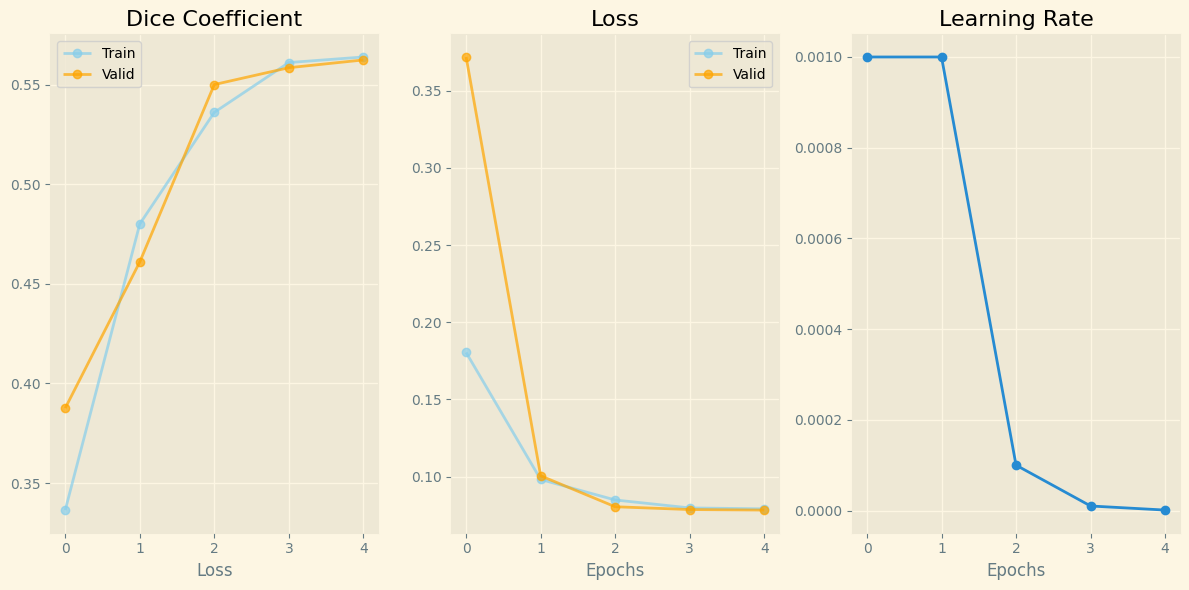

In [32]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Dice Coefficient')
plt.plot(history.history['dice_metric'], '-o', label='Train', color='skyblue', alpha=0.7)
plt.plot(history.history['val_dice_metric'], '-o', label='Valid', color='orange', alpha=0.7)
plt.xlabel('Epochs')
plt.legend()

plt.xlabel('epochs')
plt.xlabel('Loss')
plt.subplot(1,3,2)
plt.title('Loss')
plt.plot(history.history['loss'], '-o', label='Train', color='skyblue', alpha=0.7)
plt.plot(history.history['val_loss'], '-o', label='Valid', color='orange', alpha=0.7)
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,3,3)
plt.title('Learning Rate')
plt.plot(history.history['learning_rate'], '-o')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()

The provided image contains three plots showing the training history of a model over several epochs. The plots display the Dice Coefficient, Loss, and Learning Rate for both the training and validation datasets. Here's a detailed explanation of each plot:

### Left Plot: Dice Coefficient

**Title:** "Dice Coefficient"

- **X-Axis:** Epochs (number of training iterations).
- **Y-Axis:** Dice Coefficient (a measure of model performance).

**Observations:**
- **Training Dice Coefficient (Blue Line):**
  - Starts around 0.35 and increases steadily, reaching around 0.55 by epoch 4.
  - Indicates that the model's performance on the training data is improving with each epoch.

- **Validation Dice Coefficient (Orange Line):**
  - Starts slightly below 0.35 and increases similarly to the training line, reaching around 0.55 by epoch 4.
  - Indicates that the model's performance on the validation data is also improving, closely following the training performance.

**Interpretation:**
- Both training and validation Dice Coefficients are improving, suggesting that the model is learning effectively without significant overfitting.

### Middle Plot: Loss

**Title:** "Loss"

- **X-Axis:** Epochs.
- **Y-Axis:** Loss (a measure of model error).

**Observations:**
- **Training Loss (Blue Line):**
  - Starts around 0.2 and decreases sharply, reaching close to 0.05 by epoch 4.
  - Indicates that the model's error on the training data is reducing significantly with each epoch.

- **Validation Loss (Orange Line):**
  - Starts around 0.35 and decreases similarly to the training line, reaching around 0.05 by epoch 4.
  - Indicates that the model's error on the validation data is also reducing significantly, closely following the training error reduction.

**Interpretation:**
- Both training and validation losses are decreasing, confirming that the model is learning effectively and not overfitting.

### Right Plot: Learning Rate

**Title:** "Learning Rate"

- **X-Axis:** Epochs.
- **Y-Axis:** Learning Rate (the rate at which the model's weights are updated).

**Observations:**
- The learning rate starts at 0.0010 and decreases sharply to around 0.0001 by epoch 1.
- Further decreases to close to 0.00001 by epoch 2 and remains stable thereafter.

**Interpretation:**
- The learning rate is being reduced adaptively, likely due to the use of a learning rate scheduler.
- Reducing the learning rate helps in fine-tuning the model weights, allowing for more precise updates as the model converges.

### Overall Summary:

- **Model Performance:** The model is improving steadily on both training and validation data, as indicated by increasing Dice Coefficients and decreasing losses.
- **Learning Rate Adjustment:** The learning rate decreases over epochs, which helps in stabilizing the training process and preventing overshooting of the optimal weights.
- **Effectiveness:** The close alignment of training and validation metrics suggests that the model generalizes well to unseen data, indicating effective training without overfitting.

These plots provide a comprehensive view of the model's training dynamics, helping in assessing its performance and tuning the training process for better results.

## Build LinkNet

In [ ]:
'''
from segmentation_models import Linknet

res_preprocess = segmentation_models.get_preprocessing('resnet18')

linknet_model = Linknet('resnet18', input_shape=(128,800,3), classes=1, activation='sigmoid')
linknet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_metric])
'''

In [ ]:
'''
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

es = EarlyStopping(monitor='val_dice_metric', mode='max', patience=3)
checkpoint = ModelCheckpoint(f"LinkNet.weights.h5",monitor="val_dice_metric",save_best_only=True,save_weights_only=True,mode="auto",verbose=1)

# There are LearningRate Scheduler,ReduceLROnPlateau in tf.kears.callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_metric', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='auto',verbose=1)
'''

In [ ]:
'''
## Train & Valid DataGenerator
train_gen = DataGenerator(df_train.iloc[train_index], shuffle=True, batch_size=32, transform=True, preprocess=res_preprocess)
valid_gen = DataGenerator(df_train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid', preprocess=res_preprocess)

# Training
K.clear_session()
with strategy.scope(): linknet_model
history = linknet_model.fit(train_gen, verbose=1,
                   validation_data = valid_gen, epochs=5, callbacks=[es,checkpoint,reduce_lr])
'''

In [ ]:
'''
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Dice Coefficient')
plt.plot(history.history['dice_metric'], '-o', label='Train', color='skyblue', alpha=0.7)
plt.plot(history.history['val_dice_metric'], '-o', label='Valid', color='orange', alpha=0.7)
plt.xlabel('Epochs')
plt.legend()

plt.xlabel('epochs')
plt.xlabel('Loss')
plt.subplot(1,3,2)
plt.title('Loss')
plt.plot(history.history['loss'], '-o', label='Train', color='skyblue', alpha=0.7)
plt.plot(history.history['val_loss'], '-o', label='Valid', color='orange', alpha=0.7)
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,3,3)
plt.title('Learning Rate')
plt.plot(history.history['learning_rate'], '-o')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()
'''